In [1]:
%matplotlib inline

# Import common libraries and example data

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("figure", figsize=(8, 6))
matplotlib.rc("font", size=14)

In [3]:
df = pd.read_csv("data/aircraft.csv", index_col=0)

train_acs = "A320,A333,A343,A359,B737,B744,B748,B752,B763,B773,B789,C550,E145,E190"
train_acs = train_acs.split(",")

df_train = df.query("index in @train_acs")
df_test = df.query("index not in @train_acs")

x_train = df_train.length.values
y_train = df_train.max_weight.values

x_test = df_test.length.values
y_test = df_test.max_weight.values


# Visualize data

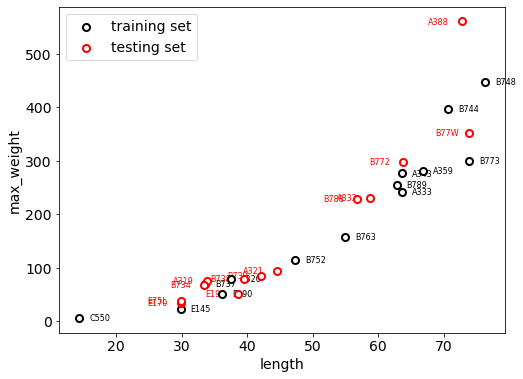

In [4]:
from common import plot_data, plot_linear_model

fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True, show_type=True)

# Polynomial linear regression

Let us represent the fuselage length and maximum weigh pairs as follows:

$$
(x_1, y_1), (x_2, y_2), \cdots ,(x_N, y_N)
$$

### Polynomial model

Now, we are going to define a polynomial model describing the relationship between $x_i$ and $y_i$:

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \cdots + \beta_k x_i^k
$$

where $\beta_k$ is the coefficient for the k-th order component.

Polynomial regression is still classified as a **linear regression problem**, since the coefficients of the model is linearly related.

Similar to the previous multiple linear regression, we can right the model in matrix format.

$$
\begin{bmatrix}
y_0 \\ y_1 \\ \vdots \\ y_N
\end{bmatrix}
=
\begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^k\\
1 & x_2 & x_2^2 & \dots & x_2^k\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_N & x_N^2 & \dots & x_N^k
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\ \beta_1 \\ \vdots \\ \beta_k
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_0 \\ \epsilon_1 \\ \vdots \\ \epsilon_n
\end{bmatrix}
$$

And can be written as:

$$
\mathbf{y} = \mathbf{X} \mathbf{\beta} + \epsilon
$$

We need to minimized the gradient of the RSS:

$$
\nabla RSS(\beta) = \frac{\partial RSS}{\partial \beta} = -2 \mathbf{X}^T(\mathbf{y} - \mathbf{X} \beta) = 0
$$

The optimal $\hat \beta$ has the closed-form solution of:

$$
\hat \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} \\
$$

## Implement the solution in Python

In [5]:
def polynomial_regression(x, y, k):

    X = np.vander(x, k+1, increasing=True)
    Y = y.reshape(-1, 1)

    res = np.dot(X.T, X)
    res = np.dot(np.linalg.inv(res), X.T)
    res = np.dot(res, Y)

    coef = res.squeeze()
    return coef

In [6]:
def print_model(coef):
    print("-" * 70)
    print(np.poly1d(coef[::-1]))
    print("-" * 70)


def plot_poly(ax, x, coef):
    x_ = np.linspace(min(x), max(x), 100)
    y_ = np.zeros(len(x_))
    for i, c in enumerate(coef):
        y_ += c * x_**i
    ax.plot(x_, y_)

## Try to fit a polynomial model

In [7]:
# select the higest order
k=3
coef = polynomial_regression(x_train, y_train, k)
print_model(coef)

----------------------------------------------------------------------
           3          2
0.0006635 x + 0.0181 x + 0.2366 x - 3.663
----------------------------------------------------------------------


### Visualize the result

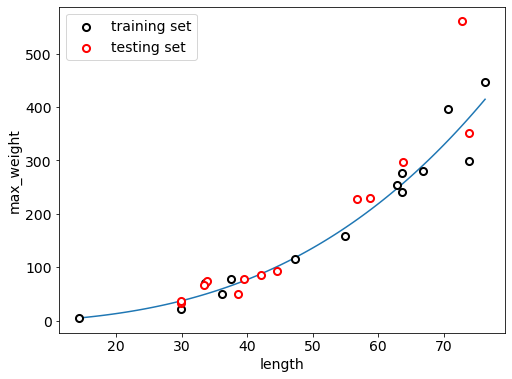

In [8]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
plot_poly(ax, x_train, coef)

# Using Scikit-Learn to perform polynomial linear regression

We can use Scikit-Learn to perform the polynomial regression. (We need to use the additional ``PolynomialFeauture``)

Note: the input parameter $X$ need to reshaped in to a 2D array.


In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

k = 3

X_train = x_train.reshape(-1, 1)
model = make_pipeline(PolynomialFeatures(k), LinearRegression())
model.fit(X_train, y_train)

_, b1, b2, b3 = model['linearregression'].coef_
b0 = model['linearregression'].intercept_

coef = [b0, b1, b2, b3]
print_model(coef)

----------------------------------------------------------------------
           3          2
0.0006635 x + 0.0181 x + 0.2366 x - 3.663
----------------------------------------------------------------------


We can see the resulting model is the same.

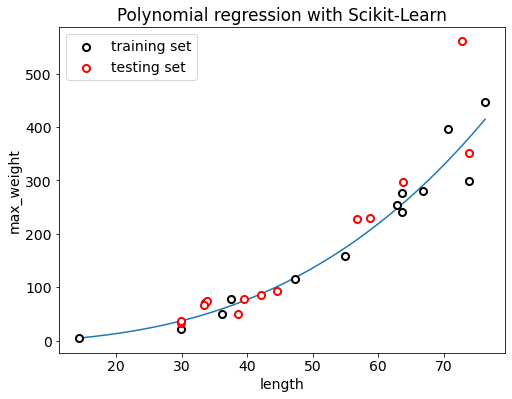

In [10]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
plot_poly(ax, x_train, coef)
ax.set_title('Polynomial regression with Scikit-Learn')
plt.show()

# Polynomial regression with `numpy`

It is also possible to perform the regression with `numpy.polyfit()`.

Note: `numpy` coefficients has a reversed order (higher order comes first in the resulting array).

In [11]:
k = 3
coef_np = np.polyfit(x_train, y_train, deg=3)
coef = coef_np[::-1]
print_model(coef)

----------------------------------------------------------------------
           3          2
0.0006635 x + 0.0181 x + 0.2366 x - 3.663
----------------------------------------------------------------------


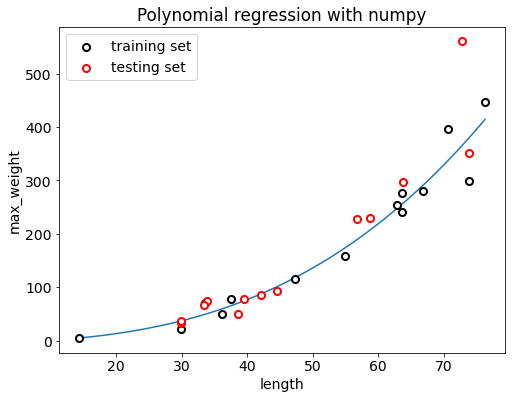

In [12]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
plot_poly(ax, x_train, coef)
ax.set_title('Polynomial regression with numpy')
plt.show()

## Evaluate the polynomial model

Let us compute the Root Mean Squared Error and $R^2$ Score

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# predict y based on test data
# pay attention to the coefficient order for np.poly1d()
y_pred = np.poly1d(coef[::-1])(x_test)

RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE:\t", RMSE.round(2))

R2 = r2_score(y_pred, y_test)
print("R2:\t", R2.round(3))

RMSE:	 58.31
R2:	 0.752


### What-if 1: we are using a linear model instead?

In [14]:
coef_1 = polynomial_regression(x_train, y_train, k=1)
y_pred_1 = np.poly1d(coef_1[::-1])(x_test)
print_model(coef_1)

----------------------------------------------------------------------
 
6.946 x - 170.7
----------------------------------------------------------------------


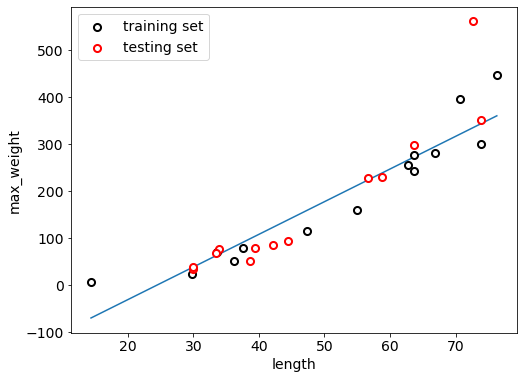

In [15]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
plot_poly(ax, x_train, coef_1)

In [16]:
RMSE = np.sqrt(mean_squared_error(y_pred_1, y_test))
print("RMSE:\t", RMSE.round(2))

R2 = r2_score(y_pred_1, y_test)
print("R2:\t", R2.round(3))

RMSE:	 66.87
R2:	 0.597


### What-if 2: we increase the polynomial order to 8?

In [17]:
coef_2 = polynomial_regression(x_train, y_train, k=8)
y_pred_2 = np.poly1d(coef_2[::-1])(x_test)
print_model(coef_2)

----------------------------------------------------------------------
           8             7             6           5         4
1.367e-08 x - 5.323e-06 x + 0.0008857 x - 0.08202 x + 4.608 x
          3        2
 - 160.2 x + 3346 x - 3.806e+04 x + 1.78e+05
----------------------------------------------------------------------


(-200.0, 600.0)

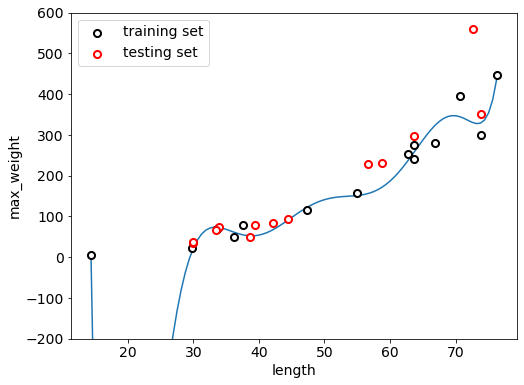

In [18]:
fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
plot_poly(ax, x_train, coef_2)
plt.ylim([-200, 600])

In [19]:
RMSE = np.sqrt(mean_squared_error(y_pred_2, y_test))
print("RMSE:\t", RMSE.round(2))

R2 = r2_score(y_pred_2, y_test)
print("R2:\t", R2.round(3))

RMSE:	 70.73
R2:	 0.558
